Jackson Kaiman, Matej Popovski

In [1]:
from pyspark import SparkContext
SparkContext.getOrCreate().stop()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/06 22:37:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "1g")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())


In [3]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [4]:
#q1
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)

count = banks_df.rdd.filter(lambda row: row["respondent_name"].startswith("The")).count()
count

298

In [5]:
#q2
count_df = banks_df.filter("respondent_name LIKE 'The%'").count()
count_df

298

In [6]:
#q3
spark.sql("CREATE DATABASE IF NOT EXISTS default")

banks_df.write.mode("overwrite").saveAsTable("default.banks")


count_sql = spark.sql("SELECT COUNT(*) FROM banks WHERE respondent_name LIKE 'The%'").collect()[0][0]
count_sql


24/11/06 22:38:28 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/06 22:38:28 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/11/06 22:38:30 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/11/06 22:38:30 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.19.0.4
24/11/06 22:38:31 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/11/06 22:38:33 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/11/06 22:38:33 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/11/06 22:38:33 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/06 22:38:33 W

298

In [7]:
# loans_df = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)

# loans_df.write.bucketBy(8, "county_code").mode("overwrite").saveAsTable("loans")

for table_name in ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
                   "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]:
    df = spark.read.csv(f"hdfs://nn:9000/{table_name}.csv", header=True, inferSchema=True)
    df.createOrReplaceTempView(table_name)



loans_df = spark.read.option("header", True).option("inferSchema", True).csv("hdfs://nn:9000/hdma-wi-2021.csv")
loans_df.write.bucketBy(8,"county_code").saveAsTable("loans", mode = "overwrite")

24/11/06 22:38:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
#q4
# loans_df.write.mode("overwrite").saveAsTable("loans")
# banks_df.write.mode("overwrite").saveAsTable("banks")

tables_df = spark.sql("SHOW TABLES")
table_dict = {row.tableName: row.isTemporary for row in tables_df.collect()}
table_dict


{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
#q5
loan_apps_count = spark.sql("""
    SELECT COUNT(*) AS count
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
""").collect()[0]["count"]

loan_apps_count

19739

In [10]:
#q6
spark.sql("""
    SELECT COUNT(*) AS count
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildLeft (7)
               :- BroadcastExchange (4)
               :  +- Project (3)
               :     +- Filter (2)
               :        +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (6)
                  +- Scan parquet spark_catalog.default.loans (5)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#65, lei_2020#69]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#65, lei_2020#69]
Condition : ((isnotnull(respondent_name#65) AND (respondent_name#65 = University of Wisconsin Credit Union)) AND i

In [11]:
#q7
import matplotlib.pyplot as plt
wells_fargo_name = "Wells Fargo Bank, National Association" 


top_10_int_rates = spark.sql(f"""
    SELECT counties.name, AVG(loans.interest_rate) AS avg_interest_rate
    FROM loans
    JOIN banks ON loans.lei = banks.lei_2020
    JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
    WHERE banks.respondent_name = '{wells_fargo_name}'
    GROUP BY counties.name
    ORDER BY COUNT(loans.interest_rate) DESC
    LIMIT 10
""").collect()


int_rate_dict = {row["name"]: row["avg_interest_rate"] for row in top_10_int_rates}
int_rate_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

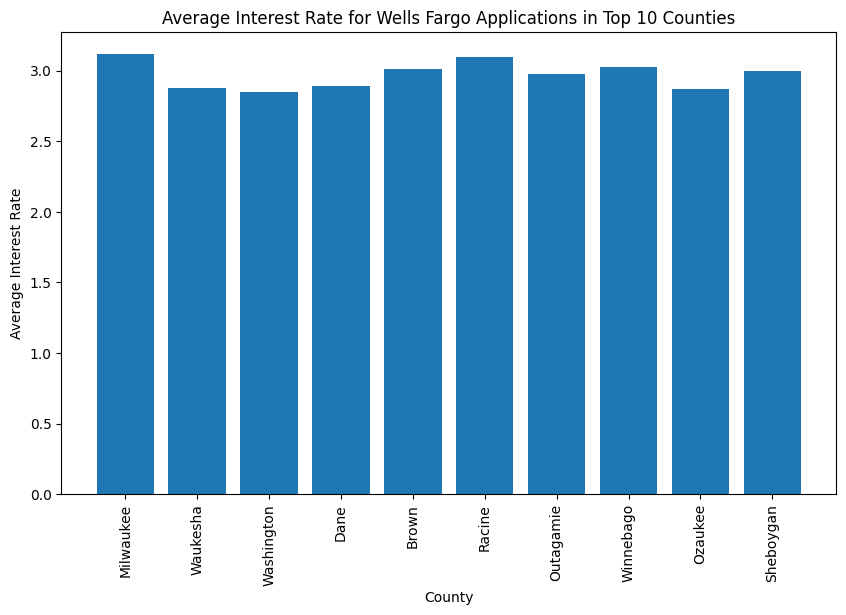

In [12]:
# Data for plotting
names = list(int_rate_dict.keys())
avg_rates = list(int_rate_dict.values())

# Bar plot
plt.figure(figsize=(10, 6)) #CHATGPT: "Answer Q7 with a Python dict that looks like this: <image>": followed with copy of my output. 
plt.bar(names, avg_rates)
plt.xlabel("County")
plt.ylabel("Average Interest Rate")
plt.xticks(rotation=90)
plt.title("Average Interest Rate for Wells Fargo Applications in Top 10 Counties")
plt.show()

In [13]:
#q8
# Group by county_code
spark.sql("SELECT county_code, AVG(interest_rate) AS avg_interest_rate FROM loans GROUP BY county_code").explain("formatted")

# Group by lei
spark.sql("SELECT lei, AVG(interest_rate) AS avg_interest_rate FROM loans GROUP BY lei").explain("formatted")



# Grouping by county_code doesn’t require network I/O because the loans table was bucketed by county_code,
# so each partition already has distinct county_code values. In contrast, grouping by lei requires a network shuffle
# since the data isn’t bucketed by lei, meaning Spark has to move data across partitions to group rows with the same lei.
# You can spot this by looking for a ShuffleExchange operation in the query plan, which signals a network shuffle.

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [county_code#992, interest_rate#1011]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,interest_rate:string>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#992, interest_rate#1011]
Keys [1]: [county_code#992]
Functions [1]: [partial_avg(cast(interest_rate#1011 as double))]
Aggregate Attributes [2]: [sum#1124, count#1125L]
Results [3]: [county_code#992, sum#1126, count#1127L]

(3) HashAggregate
Input [3]: [county_code#992, sum#1126, count#1127L]
Keys [1]: [county_code#992]
Functions [1]: [avg(cast(interest_rate#1011 as double))]
Aggregate Attributes [1]: [avg(cast(interest_rate#1011 as double))#1121]
Results [2]: [county_code#992, avg(cast(interest_rate#1011 as double))#1121

In [14]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features") # CHATGPT: Use the VectorAssembler to combine the feature columns loan_amount,income, interest_rate into a single column.


In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.pipeline import Pipeline

df = spark.sql("SELECT loan_amount, income, interest_rate, action_taken FROM loans")

df = df.withColumn("approval", when(df["action_taken"] == 1, 1.0).otherwise(0.0))

df = df.select("loan_amount", "income", "interest_rate", "approval")

df = df.withColumn("loan_amount", df["loan_amount"].cast("double")) \
       .withColumn("income", df["income"].cast("double")) \
       .withColumn("interest_rate", df["interest_rate"].cast("double")) \
       .withColumn("approval", df["approval"].cast("double"))

df = df.fillna(0.0)


train, test = df.randomSplit([0.8, 0.2], seed=41)
train.cache()

accuracies = {}




In [16]:
#q9
for depth in [1, 5, 10, 15, 20]:
    dt = DecisionTreeClassifier(labelCol="approval", featuresCol="features", maxDepth=depth, seed=41)
    pipeline = Pipeline(stages = [assembler, dt])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy") 
    accuracy = evaluator.evaluate(predictions) # CHATGPT: Train 5 DecisionTreeClassifier on your training data to predict approved based on the features by setting max depth to be 1, 5, 10, 15, 20, respectively. When creating each DecisionTreeClassifier object, please also set seed to be always 41 (which is a different process from splitting train and test split) and keep other parameters default. You won't pass autograder or our test cases if you do not do so when creating DecisionTreeClassifier objects.

    accuracies[f"depth={depth}"] = accuracy

accuracies


24/11/06 22:39:32 WARN DAGScheduler: Broadcasting large task binary with size 1073.2 KiB
24/11/06 22:39:33 WARN DAGScheduler: Broadcasting large task binary with size 1365.5 KiB
24/11/06 22:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1686.3 KiB
24/11/06 22:39:34 WARN DAGScheduler: Broadcasting large task binary with size 2040.0 KiB
24/11/06 22:39:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


{'depth=1': 0.8809425750509244,
 'depth=5': 0.8929195560947918,
 'depth=10': 0.8954796914480349,
 'depth=15': 0.8948674851679115,
 'depth=20': 0.893943610236089}

In [17]:
#q10
# Test accuracy doesn’t always go up with a higher max depth. As depth increases, the model starts fitting 
# too closely to the training data, capturing noise rather than real patterns. This is called overfitting. 
# A model that’s too deep can perform worse on test data because it’s tuned to the specifics of the training set, 
# making it less effective at generalizing to new data.